# Proyek Klasifikasi Gambar: Animals - 10
- **Nama:** Haiqel Aziizul Hakeem
- **Email:** a547ybm193@devacademy.id
- **ID Dicoding:** a547ybm193

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kagglehub
import zipfile
import os
import shutil
from PIL import Image
from google.colab import files

import tensorflowjs as tfjs

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [3]:
!pip freeze > requirements.txt

In [4]:
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Preparation

### Data Loading

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haiqelhakeem","key":"ab8ed196a5e6ef167d501eb33baa54da"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [7]:
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("animals10")

In [8]:
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "ragno": "spider"
}

In [9]:
dataset_path = "animals10/raw-img"

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path) and folder in translate:
        new_name = translate[folder]
        new_path = os.path.join(dataset_path, new_name)
        shutil.move(folder_path, new_path)
        print(f"Renamed '{folder}' to '{new_name}'")

Renamed 'scoiattolo' to 'squirrel'
Renamed 'mucca' to 'cow'
Renamed 'ragno' to 'spider'
Renamed 'pecora' to 'sheep'
Renamed 'gallina' to 'chicken'
Renamed 'farfalla' to 'butterfly'
Renamed 'cane' to 'dog'
Renamed 'gatto' to 'cat'
Renamed 'cavallo' to 'horse'
Renamed 'elefante' to 'elephant'


In [10]:
data = []

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(label_path, filename)
                data.append({"image_path": file_path, "label": label})

df = pd.DataFrame(data)
print(df.head())

                                          image_path      label
0  animals10/raw-img/butterfly/OIP-Y5_dpYEmm7Gar2...  butterfly
1  animals10/raw-img/butterfly/ea37b40820f1023ed1...  butterfly
2  animals10/raw-img/butterfly/OIP-s5sPIehyGsP7NS...  butterfly
3  animals10/raw-img/butterfly/eb32b8072bfd003ed1...  butterfly
4  animals10/raw-img/butterfly/OIP-T1NHGdUhDHlfLr...  butterfly


In [ ]:
df.nunique()

,0
image_path,26179
label,10


### Data Preprocessing

#### Split Dataset

In [11]:
# First split: train (70%) and temp (30%)
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Second split: val (15%) and test (15%)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

# Check the sizes
print(f"Train: {len(df_train)} images")
print(f"Validation: {len(df_val)} images")
print(f"Test: {len(df_test)} images")

Train: 18325 images
Validation: 3927 images
Test: 3927 images


In [12]:
print("\nTrain distribution:\n", df_train['label'].value_counts())
print("\nValidation distribution:\n", df_val['label'].value_counts())
print("\nTest distribution:\n", df_test['label'].value_counts())


Train distribution:
 label
dog          3404
spider       3375
chicken      2169
horse        1836
butterfly    1478
cow          1306
squirrel     1303
sheep        1274
cat          1168
elephant     1012
Name: count, dtype: int64

Validation distribution:
 label
dog          730
spider       723
chicken      464
horse        393
butterfly    317
cow          280
squirrel     280
sheep        273
cat          250
elephant     217
Name: count, dtype: int64

Test distribution:
 label
dog          729
spider       723
chicken      465
horse        394
butterfly    317
cow          280
squirrel     279
sheep        273
cat          250
elephant     217
Name: count, dtype: int64


In [13]:
df_train.head()

,image_path,label
1750,animals10/raw-img/butterfly/OIP-zee9w8Ff2D-Hu9...,butterfly
3346,animals10/raw-img/squirrel/OIP-9EAcnqh2TD947e2...,squirrel
12824,animals10/raw-img/spider/OIP-lvahaiEwQX8jXSo-J...,spider
17278,animals10/raw-img/horse/OIP-0UtjYA0riyhzPBqMIr...,horse
20212,animals10/raw-img/cow/OIP-ZDgK7ytrgrX2FtKqYMys...,cow


In [14]:
class_names = sorted(df_train['label'].unique())

plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(class_names):
    # Get one sample for the class
    sample_path = df_train[df_train['label'] == class_name].iloc[0]['image_path']
    image = Image.open(sample_path)

    # Plot it
    plt.subplot(3, 4, idx + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    df_train, x_col='image_path', y_col='label',
    target_size=img_size, class_mode='categorical', batch_size=batch_size)

Found 18325 validated image filenames belonging to 10 classes.


In [17]:
val_generator = val_datagen.flow_from_dataframe(
    df_val, x_col='image_path', y_col='label',
    target_size=img_size, class_mode='categorical', batch_size=batch_size)

Found 3927 validated image filenames belonging to 10 classes.


In [18]:
test_generator = test_datagen.flow_from_dataframe(
    df_test, x_col='image_path', y_col='label',
    target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 3927 validated image filenames belonging to 10 classes.


## Modelling

In [19]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 3, 3, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,436,682 (85.59 MB)

 Trainable params: 633,898 (2.42 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [21]:
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

In [22]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5942 - loss: 1.2152
Epoch 1: val_accuracy improved from -inf to 0.90349, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 161s 251ms/step - accuracy: 0.5945 - loss: 1.2145 - val_accuracy: 0.9035 - val_loss: 0.3141 - learning_rate: 1.0000e-04
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8411 - loss: 0.5046
Epoch 2: val_accuracy improved from 0.90349 to 0.91215, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 126s 220ms/step - accuracy: 0.8411 - loss: 0.5046 - val_accuracy: 0.9121 - val_loss: 0.2930 - learning_rate: 1.0000e-04
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8637 - loss: 0.4342
Epoch 3: val_accuracy did not improve from 0.91215
573/573 ━━━━━━━━━━━━━━━━━━━━ 126s 219ms/step - accuracy: 0.8637 - loss: 0.4343 - val_accuracy: 0.9058 - val_loss: 0.3028 - learning_rate: 1.0000e-04
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8628 - loss: 0.4290
Epoch 4: val_accuracy did not improve from 0.91215
573/573 ━━━━━━━━━━━━━━━━━━━━ 125s 218ms/step - accuracy: 0.8628 - loss: 0.4289 - val_accuracy: 0.9109 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8728 - loss: 0.3881
Epoch 5: val_accuracy improved from 0.91215 to 0.92030, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 125s 218ms/step - accuracy: 0.8728 - loss: 0.3881 - val_accuracy: 0.9203 - val_loss: 0.2637 - learning_rate: 1.0000e-04
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8804 - loss: 0.3664
Epoch 6: val_accuracy did not improve from 0.92030
573/573 ━━━━━━━━━━━━━━━━━━━━ 124s 216ms/step - accuracy: 0.8804 - loss: 0.3664 - val_accuracy: 0.9086 - val_loss: 0.2893 - learning_rate: 1.0000e-04
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8822 - loss: 0.3696
Epoch 7: val_accuracy did not improve from 0.92030
573/573 ━━━━━━━━━━━━━━━━━━━━ 127s 221ms/step - accuracy: 0.8822 - loss: 0.3696 - val_accuracy: 0.9139 - val_loss: 0.2751 - learning_rate: 1.0000e-04
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8817 - loss: 0.3622
Epoch 8: val_accuracy improved from 0.92030 to 0.92106, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 146s 228ms/step - accuracy: 0.8817 - loss: 0.3622 - val_accuracy: 0.9211 - val_loss: 0.2571 - learning_rate: 1.0000e-04
Epoch 9/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8824 - loss: 0.3614
Epoch 9: val_accuracy did not improve from 0.92106
573/573 ━━━━━━━━━━━━━━━━━━━━ 125s 218ms/step - accuracy: 0.8824 - loss: 0.3614 - val_accuracy: 0.9185 - val_loss: 0.2637 - learning_rate: 1.0000e-04
Epoch 10/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8886 - loss: 0.3361
Epoch 10: val_accuracy did not improve from 0.92106
573/573 ━━━━━━━━━━━━━━━━━━━━ 124s 217ms/step - accuracy: 0.8886 - loss: 0.3361 - val_accuracy: 0.9206 - val_loss: 0.2644 - learning_rate: 1.0000e-04
Epoch 11/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8915 - loss: 0.3332
Epoch 11: val_accuracy improved from 0.92106 to 0.92233, saving model to best_model.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
573/573 ━━━━━━━━━━━━━━━━━━━━ 124s 217ms/step - accuracy: 0.8915 - loss: 0.3332 - val_accuracy: 0.9223 - val_loss: 0.2592 - learning_rate: 1.0000e-04
Epoch 12/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8951 - loss: 0.3201
Epoch 12: val_accuracy improved from 0.92233 to 0.92870, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 131s 228ms/step - accuracy: 0.8952 - loss: 0.3201 - val_accuracy: 0.9287 - val_loss: 0.2508 - learning_rate: 2.0000e-05
Epoch 13/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9014 - loss: 0.2998
Epoch 13: val_accuracy did not improve from 0.92870
573/573 ━━━━━━━━━━━━━━━━━━━━ 124s 216ms/step - accuracy: 0.9014 - loss: 0.2997 - val_accuracy: 0.9272 - val_loss: 0.2494 - learning_rate: 2.0000e-05
Epoch 14/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8990 - loss: 0.3010
Epoch 14: val_accuracy did not improve from 0.92870
573/573 ━━━━━━━━━━━━━━━━━━━━ 123s 215ms/step - accuracy: 0.8990 - loss: 0.3010 - val_accuracy: 0.9246 - val_loss: 0.2529 - learning_rate: 2.0000e-05
Epoch 15/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9041 - loss: 0.2853
Epoch 15: val_accuracy did not improve from 0.92870
573/573 ━━━━━━━━━━━━━━━━━━━━ 126s 220ms/step - accuracy: 0.9041 - loss: 0.2853 - val_accuracy: 0.9256 - val_loss: 0.2483 - learnin

In [23]:
model = load_model('best_model.h5')

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Evaluasi dan Visualisasi

In [24]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9298 - loss: 0.2139
Test Loss: 0.2323
Test Accuracy: 0.9244


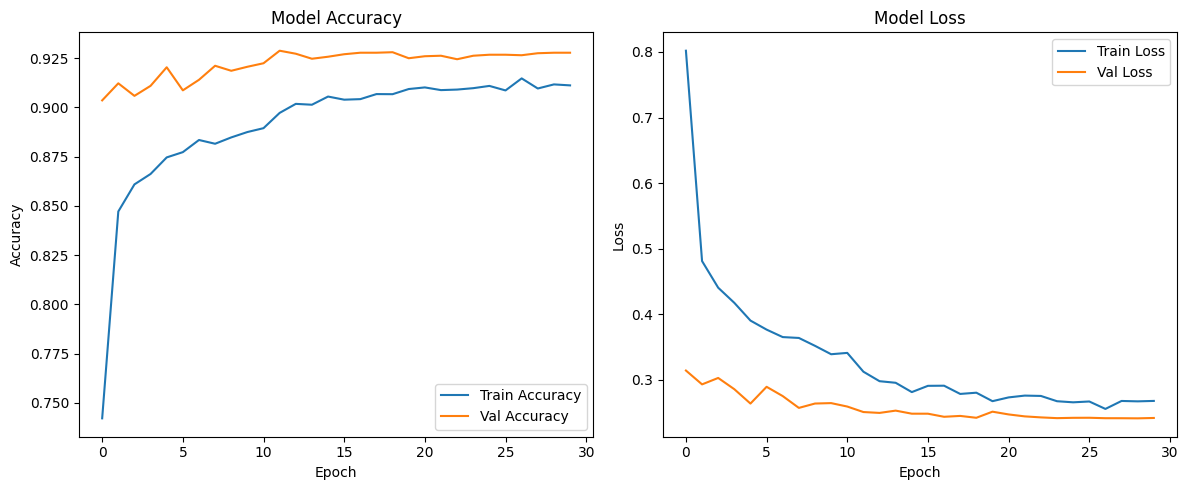

In [25]:
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [26]:
# Saved Model
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [27]:
saved_model = "/content/saved_model"
model.export(saved_model)
print(f"SavedModel: {saved_model}")

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133273917039120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916118352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916122000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916118160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916115280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916121040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916119888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916121424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916120080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133273916119696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13327391

In [28]:
!zip -r saved_model.zip /content/saved_model/

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 91%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 78%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)


In [29]:
# TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("mymodel/")
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [30]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/mymodel \
    /content/tfjs_model

2025-05-12 15:27:22.217864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747063642.238084   18861 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747063642.244106   18861 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-12 15:27:27.175796: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747063647.175998   18861 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [31]:
!zip -r tfjs_model.zip /content/tfjs_model

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard2of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard18of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard11of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard7of22.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 97%)
  adding: content/tfjs_model/group1-shard21of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard10of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard15of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard13of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard6of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard1of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard16of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard20of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard19of22.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard12of22.b

In [32]:
from google.colab import files
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [34]:
loaded = tf.saved_model.load('mymodel/')
infer = loaded.signatures['serving_default']

In [35]:
def preprocess_img_tf(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_tensor = tf.convert_to_tensor([img_array])
    return img_tensor

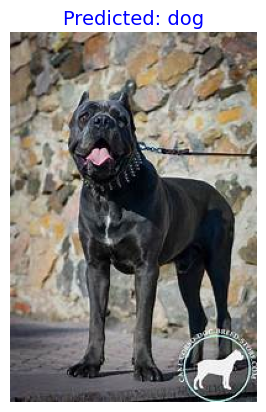

In [36]:
img_path = '/content/dog.jpeg'
img_tensor = preprocess_img_tf(img_path)
pred = infer(img_tensor)
output = list(pred.values())[0]
class_idx = tf.argmax(output, axis=1).numpy()[0]
img = load_img(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[class_idx]}", fontsize=14, color='blue')
plt.show()

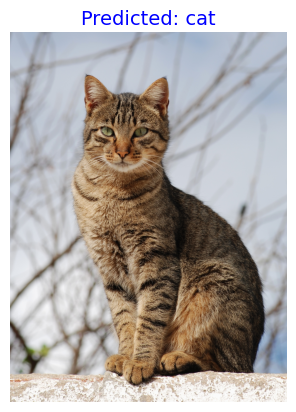

In [37]:
img_path = '/content/Cat_November_2010-1a.jpg'
img_tensor = preprocess_img_tf(img_path)
pred = infer(img_tensor)
output = list(pred.values())[0]
class_idx = tf.argmax(output, axis=1).numpy()[0]
img = load_img(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[class_idx]}", fontsize=14, color='blue')
plt.show()

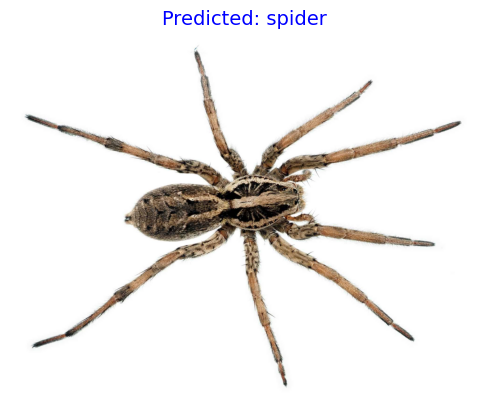

In [38]:
img_path = '/content/wolf-spider.jpg'
img_tensor = preprocess_img_tf(img_path)
pred = infer(img_tensor)
output = list(pred.values())[0]
class_idx = tf.argmax(output, axis=1).numpy()[0]
img = load_img(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[class_idx]}", fontsize=14, color='blue')
plt.show()

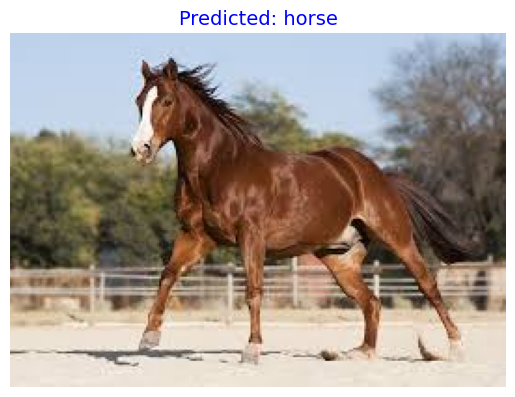

In [39]:
img_path = '/content/horse.jpeg'
img_tensor = preprocess_img_tf(img_path)
pred = infer(img_tensor)
output = list(pred.values())[0]
class_idx = tf.argmax(output, axis=1).numpy()[0]
img = load_img(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[class_idx]}", fontsize=14, color='blue')
plt.show()

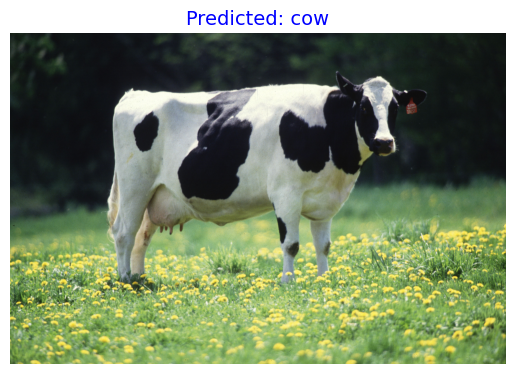

In [40]:
img_path = '/content/Cow_female_black_white.jpg'
img_tensor = preprocess_img_tf(img_path)
pred = infer(img_tensor)
output = list(pred.values())[0]
class_idx = tf.argmax(output, axis=1).numpy()[0]
img = load_img(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[class_idx]}", fontsize=14, color='blue')
plt.show()